# Ok, as you read this is a simple solution for predicting prices
> **The Steps(Pipeline) we will do here:**
>    1. *Clarify features' names and make some thoughts about them (we will see which of them may be true in EDA)*
>    2. *Explore our data as quick lookup*
>    3. *Exploratory Data Analysis (EDA)*
>    4. *Make Some Decisions*
>    5. *Clean and handle missing data*
>    6. *Prepare our data for ML (Transform strings into categorical data but integers or floats)*
>    7. *Normality*
>    8. *ML*

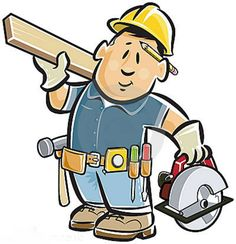

# **Let's Go on** 

**Importing Libraries & Modules**

In [ ]:
# Data Analysis
import numpy as np
import pandas as pd
import random

# Statistics
from scipy.stats import norm
from scipy import stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

# ML
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

# Another
import warnings
warnings.filterwarnings('ignore')

**Load Project Data**

In [ ]:
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

> # Features' names quick look

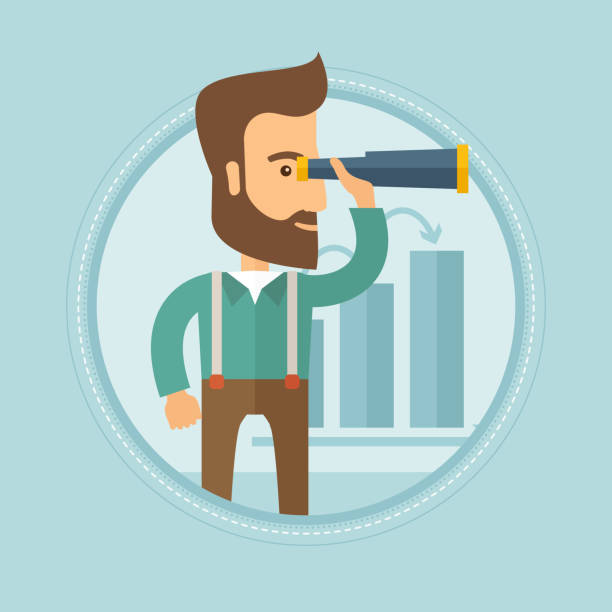

**All features' names we don't know will be in the 'data_description.txt' file, so do check it**

In [ ]:
train_data.columns.values

**Check the you-don't-know feature's name from that text file  '../input/house-prices-advanced-regression-techniques/data_description.txt'**

> # Explore

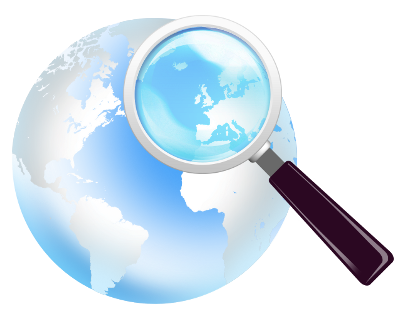

In [ ]:
print(train_data.head())
print('-'*20)
print(train_data.info())

# **As we can see here there are a lot of features** 
**we can classify it by two ways:**
   * number of non-null values
   * categorical & numerical
   
   

**let's begin with number of non-null values:**
1. full (from it's name)
2. medium (have some missing data)
3. Remove_me (data have more than 50% missing data)

**Note:**
*I think there is forth category called funny which have one feature (PoolQC) if you don't understand me check it*

In [ ]:
# Now let's put each category in it's own dataframe and then collect them
# I will make the code very easy to understand so don't worry if you're beginner

full = pd.DataFrame()
medium = pd.DataFrame()
remove_me = pd.DataFrame()

features = train_data.columns.values
number_of_houses = 1460 # try writing it train_data.shape[0]

for feature in features:
    if train_data[feature].count() == number_of_houses:
        full[feature] = train_data[feature]
    elif train_data[feature].count() > number_of_houses * 0.5: # Actually, that mean it has more than 50% non-null values
        medium[feature] = train_data[feature]
    else:
        remove_me[feature] = train_data[feature]

**now, let's classify them as numerical and categorical**:
  * Numerical (refers to value)
  * Categorical (string refers to string or number refers to string)

**Numerical**

In [ ]:
print('Number of numerical features: ', end='')
print(len(train_data.select_dtypes(include=['number']).columns.values))
train_data.describe(exclude=['O'])

**Categorical**

In [ ]:
print('Number of categorical features: ', end='')
print(len(train_data.select_dtypes(include=['O']).columns.values))
train_data.describe(include=['O'])

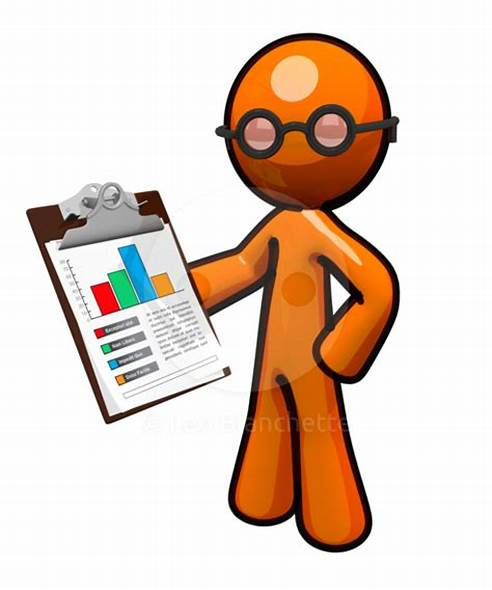

# **Now let's see what we have:**
  * we knew the features that should be removed and put them in a dataframe called 'remove_me'
  * we knew the features that we must complete them and put them in a dataframe called 'medium'
  * we knew that categorical data have a small number of unique value and that will help us use get_dummies() method instead of other hard tools
  * we knew that Id means nothing

*Let's go to the next step*

> # Exploratory Data Analysis (EDA)

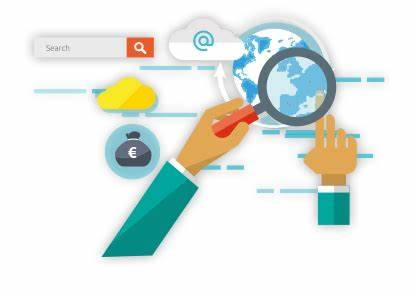

**Our target**

In [ ]:
plt.hist(train_data['SalePrice'])
plt.title('Sale Prices')
plt.show()

**let's try to reduce the number of features by know the meaningless features**

**we will drop:**
  1. id -> because it means nothing
  2. all features in remove_me DataFrame
  3. tricky features: the features that tells you that it hasn't a lot of missing values but most of it's values are equals to zero 
*(ex: when you tell me what is the area of your pool and I say zero)*

In [ ]:
#1
train_data = train_data.drop(['Id'], axis=1)

#2
train_data = train_data.drop(remove_me.columns.values, axis=1)

#3

# First let's create the important data we will use
numerical_data = train_data.select_dtypes(include=['number'])
categorical_data = train_data.select_dtypes(include=['object'])

# we want to know the ratio of (values equals zero) / 1460
# to each feature and if the feature has more than 50% ratio we will remove it
feature_zero_ratio = {feature:numerical_data.loc[numerical_data[feature] == 0, feature].count() / 1460 for feature in numerical_data.columns.values}
feature_zero_ratio

***Now let's drop features having more than 0.30 ratio***

In [ ]:
for feature in numerical_data:
    if feature_zero_ratio[feature] > 0.30:
        numerical_data = numerical_data.drop([feature], axis=1)
        train_data = train_data.drop([feature], axis=1)
        if feature in medium:
            medium = medium.drop([feature], axis=1)

train_data.shape

**Now we want to see the relationship between numerical data and the target**

In [ ]:
print(numerical_data.columns.values)
print(len(numerical_data.columns.values))

corrmat = numerical_data.corr()
fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, annot=True, square=True, annot_kws={'size': 8}, fmt='.2f')
plt.show()

**Let's zoom in to the most 10 largest relationship**

In [ ]:
n = 10
most_largest_features = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index
zoomed_corrmat = np.corrcoef(numerical_data[most_largest_features].values.T)
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1)
sns.heatmap(zoomed_corrmat, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=most_largest_features.values, xticklabels=most_largest_features.values)
print(most_largest_features.values)

**Now let's see the relations of the seven largest in graph (scatter plot)**

In [ ]:
sns.set()
most_largest_features = corrmat.nlargest(7, 'SalePrice')['SalePrice'].index
sns.pairplot(numerical_data[most_largest_features.values], size=1.5)
plt.show()
print(most_largest_features)

**we can see that some features have a linear relationship so we can remove any of them let's remove the lowest one have relation with target:**
  * GrLivArea and 1stFlrSF --> the removed one (1stFlrSF)
  * GrLivArea and TotalBsmtSF --> the removed one (TotalBsmtSF)
  * GarageCars and GarageArea --> the removed one (GarageArea)
  * YearBuilt and GarageYrBlt --> the removed one (GarageYrBlt)

In [ ]:
numerical_data = numerical_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'], axis=1)
train_data = train_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'], axis=1)
numerical_data.columns.values

**Last thing from these graphs and heatmaps: we will remove the nutral features**
*     *Nutral Features : features have a relationship with 'SalePrice' in this range [-0.1, 0.2]*

In [ ]:
corr_with_price = numerical_data.corr()
corr_with_price = corr_with_price.sort_values(by= 'SalePrice', ascending=False)
corr_with_price['SalePrice']

In [ ]:
numerical_data.columns.values

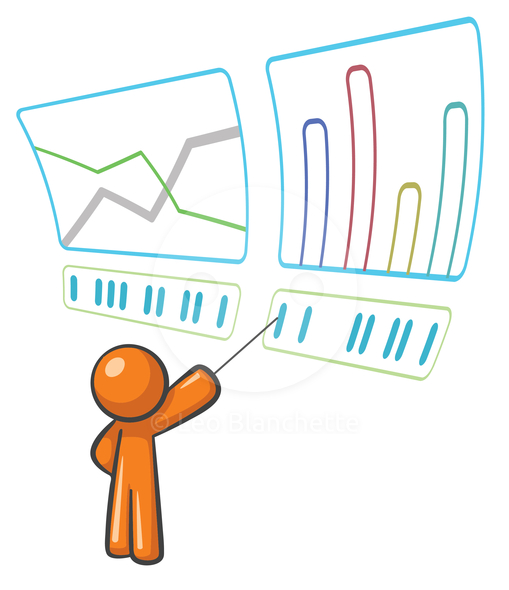

**Let's see what we have:**
  * we knew the relationship between each feature and the target
  * we knew also the relationship among the features
  * we reduce the number of numerical features from 38 to 17
  

> # **Handling Missing Data**

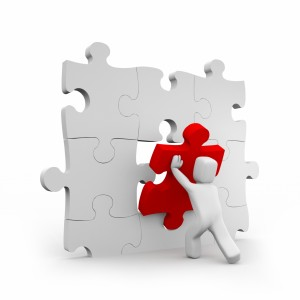

**Now let's impute the missing data which is in the 'medium' we can do that with several ways:**
 * numerical
   1. give it the value of the median
   2. give it the value of the mean
   3. give it a random value from (mean - std) to (mean + std)
 * categorical
   1. give it the value of the mode (the most appeared value)
   2. do some analysis more, then do step 1 to decrease the ratio of the wrong values

In [ ]:
numerical_have_missing = pd.DataFrame()
categorical_have_missing = pd.DataFrame()

# Numerical
for feature in numerical_data.columns.values:
    if feature in medium:
        numerical_have_missing[feature] = numerical_data[feature]
      
    
# Categorical
for feature in categorical_data.columns.values:
    if feature in medium:
        categorical_have_missing[feature] = categorical_data[feature]


# **So our data are prepared**
*let's begin with numerical*

In [ ]:
print(numerical_have_missing.columns.values)
print('-'*30)
print(numerical_have_missing.info())

**So we have just two numerical features with missing values**

In [ ]:
sns.histplot(numerical_have_missing['LotFrontage'])
plt.title('LotFrontage')
plt.show()

**According to those to histogram, why don't we give the missing values that:**
  * *LotFrontage --> random value from 60 to 80*
  


In [ ]:
# Let's code it
old_LotFrontage = list(numerical_have_missing['LotFrontage'].values)
missing_indices = list(numerical_have_missing.loc[numerical_have_missing['LotFrontage'].isnull(), 'LotFrontage'].index)
random_values = [random.randint(60, 80) for _ in range( 1460 - numerical_have_missing['LotFrontage'].count() ) ]
random_values_idx = 0

for missing_idx in missing_indices:
        
    old_LotFrontage[missing_idx] = random_values[random_values_idx]
    random_values_idx += 1
        

numerical_have_missing['LotFrontage'] = pd.Series(old_LotFrontage)
train_data['LotFrontage'] = pd.Series(old_LotFrontage)

print(numerical_have_missing['LotFrontage'].count())
print(train_data['LotFrontage'].count())


**Now let's focus on categorical data with missing values**

In [ ]:
print(len(categorical_have_missing.columns.values))
print('-'*30)
print(categorical_have_missing.columns.values)
print('-'*30)
print(categorical_have_missing.count())

*We will remove '**FireplaceQu**' as it has a lot of missing values and **impute** the last values with the **most frequent** value*

In [ ]:
train_data = train_data.drop(['FireplaceQu'], axis=1)
categorical_have_missing = categorical_have_missing.drop(['FireplaceQu'], axis=1)

In [ ]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
for feature in categorical_have_missing:
    
    categorical_have_missing[feature] = imputer.fit_transform(categorical_have_missing[feature].values.reshape((-1, 1)))
    train_data[feature] = imputer.fit_transform(train_data[feature].values.reshape((-1, 1)))

**Check again**

In [ ]:
print(len(categorical_have_missing.columns.values))
print('-'*30)
print(categorical_have_missing.columns.values)
print('-'*30)
print(categorical_have_missing.count())

***So there is no missing values any more***

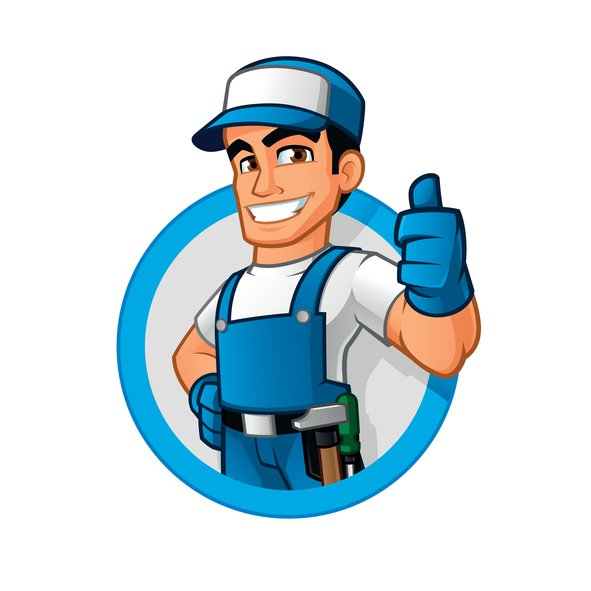

> # ***Outliers !***

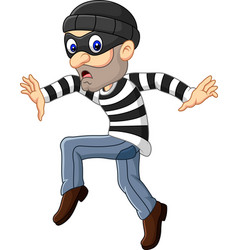

*From the graphs above there is an outliers with 'GrLivArea'*, **what you will not go and check it !!**, *okay I will plot it again.* 

In [ ]:
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.show()

Now as you can see we have to outliers and .... **what ?! really you don't see them**, *ooh man why are you strange, okay I will make it easy to you now see this.*

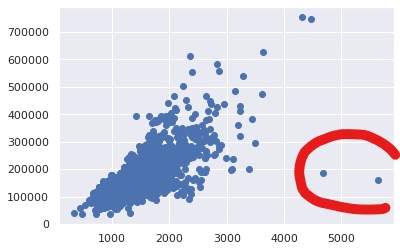

*Now we want to remove those two houses who have those* **outliers**.

In [ ]:
train_data[ (train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 200000)].index

In [ ]:
# Let's return Id and remove it later.
train_data['Id'] = pd.Series(train_data.index)

**so we want remove houses which have the indices of [523, 1298]**

In [ ]:
train_data = train_data.drop( train_data[ (train_data['Id'] == 1298) | (train_data['Id'] == 523) ].index)

In [ ]:
test_data = test_data[train_data.drop(['SalePrice'], axis=1).columns.values]
# Delete Id again
train_data = train_data.drop(['Id'], axis=1)

**Let's check it.**

In [ ]:
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.show()
print(train_data.shape)

> # ***Dummies (change the categorical into it's equivalent numerical)***

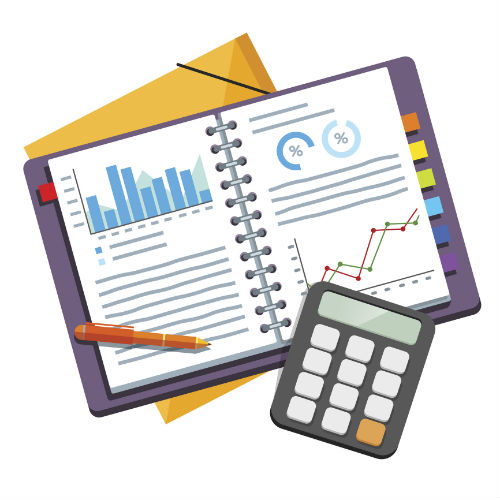

In [ ]:
train_data = pd.get_dummies(train_data)

> # ***Normality (Some Statistics)***

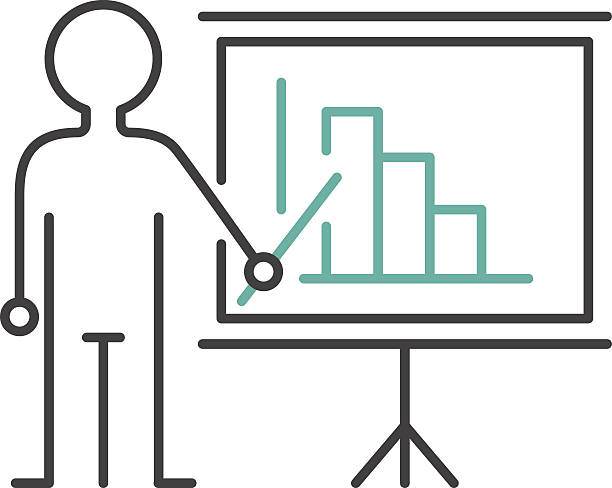

*I will leave the resources of that in the comments, but just focus:*
  * **Normality** - *When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.*

  * **Homoscedasticity** - *I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' (Hair et al., 2013). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.*

* **Histogram** - *Kurtosis and skewness.*
* **Normal probability plot** - *Data distribution should closely follow the diagonal that represents the normal distribution.*

In [ ]:
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

As we can see 'SalePrice' is **not normal distributed** has **positive skewness** and don't follow the diagonal line, 
But we can solve that easily by take the log of it.

In [ ]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

Let's do the same with '**GrLivArea**'

In [ ]:
sns.distplot(train_data['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

Same **problem**, so same **solution**

In [ ]:
train_data['GrLiveArea'] = np.log(train_data['GrLivArea'])
sns.distplot(train_data['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['GrLivArea'], plot=plt)

In [ ]:
train_data.shape

> # ***ML***

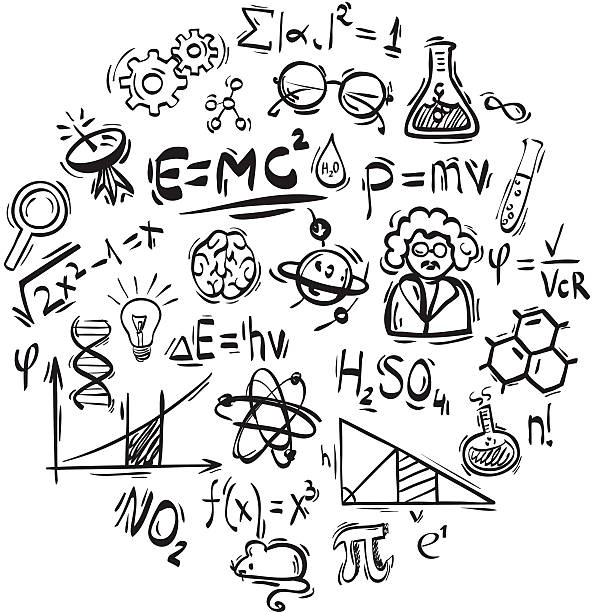

In [ ]:
target = train_data['SalePrice']
train_data = train_data.drop(['SalePrice'], axis=1)

X, y = train_data, target

**LinearRegression**

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
pred = lin_reg.predict(X)
print(lin_reg.score(X, y))
np.sqrt(mean_squared_log_error(pred, y))

**RandomForestRegressor**

In [ ]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X, y)
pred = forest_reg.predict(X)
print(forest_reg.score(X, y))
np.sqrt(mean_squared_log_error(pred, y))

**XGBRegressor**

In [ ]:
xg_reg = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 300, seed = 123)
xg_reg.fit(X, y)
pred = xg_reg.predict(X)
print(xg_reg.score(X, y))
np.sqrt(mean_squared_log_error(pred, y))

*So the best Model is* **XGBRegressor**

> # ***Final***

the coming kernels is for my submission, you can ignore

In [ ]:
print(test_data.head())
print('-'*20)
print(test_data.info())


In [ ]:
sns.histplot(numerical_have_missing['LotFrontage'])
plt.title('LotFrontage')
plt.show()

In [ ]:
# Let's code it
old_LotFrontage = list(test_data['LotFrontage'].values)
missing_indices = list(test_data.loc[test_data['LotFrontage'].isnull(), 'LotFrontage'].index)
random_values = [random.randint(60, 80) for _ in range( 1460 - test_data['LotFrontage'].count() ) ]
random_values_idx = 0

for missing_idx in missing_indices:
        
    old_LotFrontage[missing_idx] = random_values[random_values_idx]
    random_values_idx += 1
        

test_data['LotFrontage'] = pd.Series(old_LotFrontage)
print(test_data['LotFrontage'].count())

In [ ]:
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
for feature in test_data.drop(['LotFrontage'], axis=1):
    
    test_data[feature] = imputer.fit_transform(test_data[feature].values.reshape((-1, 1)))
    test_data[feature] = imputer.fit_transform(test_data[feature].values.reshape((-1, 1)))
    
test_data = pd.get_dummies(test_data)
print(test_data.isnull().sum().max())
print(test_data.shape)

In [ ]:
print(test_data.head())
print('-'*20)
print(test_data.info())

In [ ]:

rest = set(X.columns.values) - set(list(test_data.columns.values))
for feature in list(rest):
    test_data[feature] = 0

> # **Submission**

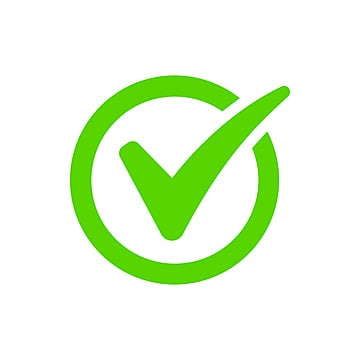

In [ ]:
ids = test_data['Id']
test_data = test_data.drop(['Id'], axis=1)
ourPred = xg_reg.predict(test_data)
submission = pd.DataFrame({
        "Id": ids,
        "SalePrice": ourPred
    })
submission.to_csv('submission.csv', index=False)